In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
import numpy as np
from sklearn import tree
import sklearn.linear_model as lm
from sklearn import preprocessing, model_selection, pipeline
from sklearn.model_selection import validation_curve
from sklearn import metrics
from sklearn.inspection import permutation_importance



from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets


np.set_printoptions(precision=3)
pandas.set_option("display.precision", 3)



classification_scores = ['accuracy','precision_weighted',
                         'recall_weighted', 'roc_auc_ovr_weighted',
                         'f1_weighted']


regression_scores = ['explained_variance','neg_mean_absolute_error',
                     'neg_mean_absolute_percentage_error', 'r2',
                     'neg_root_mean_squared_error']

%matplotlib inline

In [2]:
sorted(metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

# Classificacao

## Vinhos


### Leitura da Base 

In [3]:
df_wine = pandas.read_csv('../Data/dataset_vinhos.csv',sep=';')


wine_target_col = 'target'

wine_label_map = df_wine[['target', 'target_label']].drop_duplicates()

drop_cols = ['target_label']
df_wine.drop(drop_cols, axis=1, inplace=True)
print(df_wine.shape)
df_wine.head()

(5320, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,target,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.998,3.51,0.56,9.4,0,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.997,3.20,0.68,9.8,0,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8,0,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58,9.8,1,red
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.998,3.51,0.56,9.4,0,red


### Transformação Variáveis Categóricas

In [4]:
categorical_cols = ['type']
encoder_map = {}

for cname in categorical_cols:
    encoder = preprocessing.OneHotEncoder(sparse=False)
    transformed = encoder.fit_transform(df_wine[[cname]])
    ohe_df = pandas.DataFrame(transformed, columns=[cname+'_'+cat for cat in encoder.categories_[0]])
    encoder_map[cname] = encoder
    
    df_wine = pandas.concat([df_wine, ohe_df], axis=1).drop(cname, axis=1)
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,target,type_red,type_white
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.998,3.51,0.56,9.4,0,1.0,0.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.997,3.20,0.68,9.8,0,1.0,0.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8,0,1.0,0.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58,9.8,1,1.0,0.0
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.998,3.51,0.56,9.4,0,1.0,0.0


## Treinamento dos modelos

In [5]:
Y = df_wine[wine_target_col]
X = df_wine.drop(wine_target_col, axis=1)

# train/test
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(X, Y, test_size=0.2)

cvfold = model_selection.StratifiedKFold(n_splits = 10, random_state = 0, shuffle=True)


### Regressão Logística 

#### Curva de Validação-Cruzada 

In [6]:

grid_search_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none']
}


def plot_parameter_validation_curve(param_name, grid_search,
                                    model, model_name, scoring,
                                    logx):
    print('Parameter:', param_name)
    print('GridSearch:', grid_search[param_name])
    print('Scoring:', scoring)
    plt.figure(figsize=(10,4))
    train_scores, test_scores = validation_curve(model,
                                                 X = xtrain, 
                                                 y = ytrain, 
                                                 param_name=param_name, 
                                                 param_range= grid_search[param_name],
                                                 scoring=scoring,
                                                 cv=cvfold,
                                                 n_jobs=-1)
    print(train_scores)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.title("Curva Validação Modelo " + model_name)
    plt.xlabel(param_name)
    plt.ylabel("Score ("+scoring+")")
    if logx:
        plt.semilogx(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plt.semilogx(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                     color="navy", lw=2)
    else:
        plt.plot(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plt.plot(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                 color="navy", lw=2)
    plt.fill_between(grid_search[param_name], train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=2)
    plt.fill_between(grid_search[param_name], test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=2)
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()
    
interact(plot_parameter_validation_curve,
         param_name = list(grid_search_lr.keys()), 
         grid_search = fixed(grid_search_lr),
         model = fixed(lm.LogisticRegression(solver='liblinear')),
         model_name = fixed('Regressão Logística'),
         scoring = classification_scores,
         logx = True
)


interactive(children=(Dropdown(description='param_name', options=('C', 'penalty'), value='C'), Dropdown(descri…

<function __main__.plot_parameter_validation_curve(param_name, grid_search, model, model_name, scoring, logx)>

#### Curva de Aprendizado 

In [7]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


train_sizes = np.linspace(.1, 1.0, 10)


def plot_learning_curve(model, model_name, scoring, train_sizes):
    plt.figure(figsize=(10,4))
    ax = plt.gca()
        
    ax.set_title('Curva de Aprendizado (%s)'%model_name)
    ax.set_xlabel("Exemplos do Treino")
    ax.set_ylabel("Score (" + scoring + ")")

    train_sizes, train_scores, test_scores = learning_curve(model,
                                                            X = xtrain,
                                                            y = ytrain,
                                                            cv=cvfold,
                                                            n_jobs=-1,
                                                            train_sizes=train_sizes,
                                                            scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Plot learning curve
    ax.grid()
    ax.plot(train_sizes, train_scores_mean, 'o-', color="darkorange",
                 label="Treino")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="navy",
                 label="Validação-cruzada")
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="darkorange")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="navy")
    ax.legend(loc="best")
    plt.show()

    
interact(plot_learning_curve,
         model = fixed(lm.LogisticRegression(solver='liblinear', C=1)),
         model_name = fixed('Regressão Logística'),
         scoring = classification_scores,
         train_sizes=fixed(train_sizes)
)


interactive(children=(Dropdown(description='scoring', options=('accuracy', 'precision_weighted', 'recall_weigh…

<function __main__.plot_learning_curve(model, model_name, scoring, train_sizes)>

### Árvore de Decisão 

#### Curva de Validação-Cruzada 

In [8]:

grid_search_dt = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 4, 6, 8],
    'max_features': ["auto", "sqrt", "log2"],
}


interact(plot_parameter_validation_curve,
         param_name = list(grid_search_dt.keys()), 
         grid_search = fixed(grid_search_dt),
         model = fixed(tree.DecisionTreeClassifier()),
         model_name = fixed('Árvore de Decisão'),
         scoring = classification_scores,
         logx = True
)


interactive(children=(Dropdown(description='param_name', options=('max_depth', 'criterion', 'min_samples_split…

<function __main__.plot_parameter_validation_curve(param_name, grid_search, model, model_name, scoring, logx)>

#### Curva de Aprendizado 

In [9]:
train_sizes = np.linspace(.1, 1.0, 10)
    

interact(plot_learning_curve,
         model = fixed(tree.DecisionTreeClassifier(max_depth=5,
                                                   )),
         model_name = fixed('Árvore de Decisão'),
         scoring = classification_scores,
         train_sizes=fixed(train_sizes)
)


interactive(children=(Dropdown(description='scoring', options=('accuracy', 'precision_weighted', 'recall_weigh…

<function __main__.plot_learning_curve(model, model_name, scoring, train_sizes)>

## Íris 

## Leitura da Base 

In [10]:
df_iris = pandas.read_csv('../Data/dataset_iris.csv',sep=';')

iris_label_map = df_iris[['target', 'target_label']].drop_duplicates()

drop_cols = ['target_label']
df_iris.drop(drop_cols, axis=1, inplace=True)

print(df_iris.shape)

iris_target_col = 'target'


df_iris.head()

(150, 5)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## Treinamento dos Modelos 

In [11]:

Y = df_iris[iris_target_col]
X = df_iris.drop(iris_target_col, axis=1)
iris_feature_names = list(X.columns)

# train/test
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(X, Y, test_size=0.2)

cvfold = model_selection.StratifiedKFold(n_splits = 10, random_state = 0, shuffle=True)

### Regressão Logística 

#### Curva de Validação-Cruzada 

In [12]:

grid_search_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none']
}

interact(plot_parameter_validation_curve,
         param_name = list(grid_search_lr.keys()), 
         grid_search = fixed(grid_search_lr),
         model = fixed(lm.LogisticRegression(solver='liblinear')),
         model_name = fixed('Regressão Logística'),
         scoring = classification_scores,
         logx = True
)


interactive(children=(Dropdown(description='param_name', options=('C', 'penalty'), value='C'), Dropdown(descri…

<function __main__.plot_parameter_validation_curve(param_name, grid_search, model, model_name, scoring, logx)>

#### Curva de Aprendizado 

In [13]:
train_sizes = np.linspace(.1, 1.0, 10)
    
interact(plot_learning_curve,
         model = fixed(lm.LogisticRegression(solver='liblinear', C=1)),
         model_name = fixed('Regressão Logística'),
         scoring = classification_scores,
         train_sizes=fixed(train_sizes)
)


interactive(children=(Dropdown(description='scoring', options=('accuracy', 'precision_weighted', 'recall_weigh…

<function __main__.plot_learning_curve(model, model_name, scoring, train_sizes)>

### Árvore de Decisão 

#### Curva de Validação-Cruzada 

In [14]:
grid_search_dt = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 4, 6, 8],
    'max_features': ["auto", "sqrt", "log2"],
}

interact(plot_parameter_validation_curve,
         param_name = list(grid_search_dt.keys()), 
         grid_search = fixed(grid_search_dt),
         model = fixed(tree.DecisionTreeClassifier()),
         model_name = fixed('Árvore de Decisão'),
         scoring = classification_scores,
         logx = True
)

interactive(children=(Dropdown(description='param_name', options=('max_depth', 'criterion', 'min_samples_split…

<function __main__.plot_parameter_validation_curve(param_name, grid_search, model, model_name, scoring, logx)>

#### Curva de Aprendizado 

In [15]:
train_sizes = np.linspace(.1, 1.0, 10)
    

interact(plot_learning_curve,
         model = fixed(tree.DecisionTreeClassifier(max_depth=5,
                                                   )),
         model_name = fixed('Árvore de Decisão'),
         scoring = classification_scores,
         train_sizes=fixed(train_sizes)
)


interactive(children=(Dropdown(description='scoring', options=('accuracy', 'precision_weighted', 'recall_weigh…

<function __main__.plot_learning_curve(model, model_name, scoring, train_sizes)>

In [16]:

Y = df_wine[wine_target_col]
X = df_wine.drop(wine_target_col, axis=1)
wine_feature_names = list(X.columns)

# train/test
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(X, Y, test_size=0.2)

df_train = xtrain.copy()
df_test = xtest.copy()
df_train['train_set'] = 1
df_test['train_set'] = 0
df_train[wine_target_col] = ytrain
df_test[wine_target_col] = ytest


model_wine = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 4)
model_wine.fit(xtrain, ytrain)      
df_train['decision_tr'] = model_wine.predict(xtrain)
df_test['decision_tr']  = model_wine.predict(xtest)
df_train['probability_tr'] = model_wine.predict_proba(xtrain)[:,1]
df_test['probability_tr']  = model_wine.predict_proba(xtest)[:,1]

df_wine_tr = pandas.concat((df_train, df_test), axis=0)


idx = df_wine_tr['train_set'] == 0

print('Logistic\t', metrics.accuracy_score(df_wine_tr[idx][wine_target_col],
                                           df_wine_tr[idx]['probability_tr']>0.5))

Logistic	 0.7152255639097744


### Estrutura Árvore

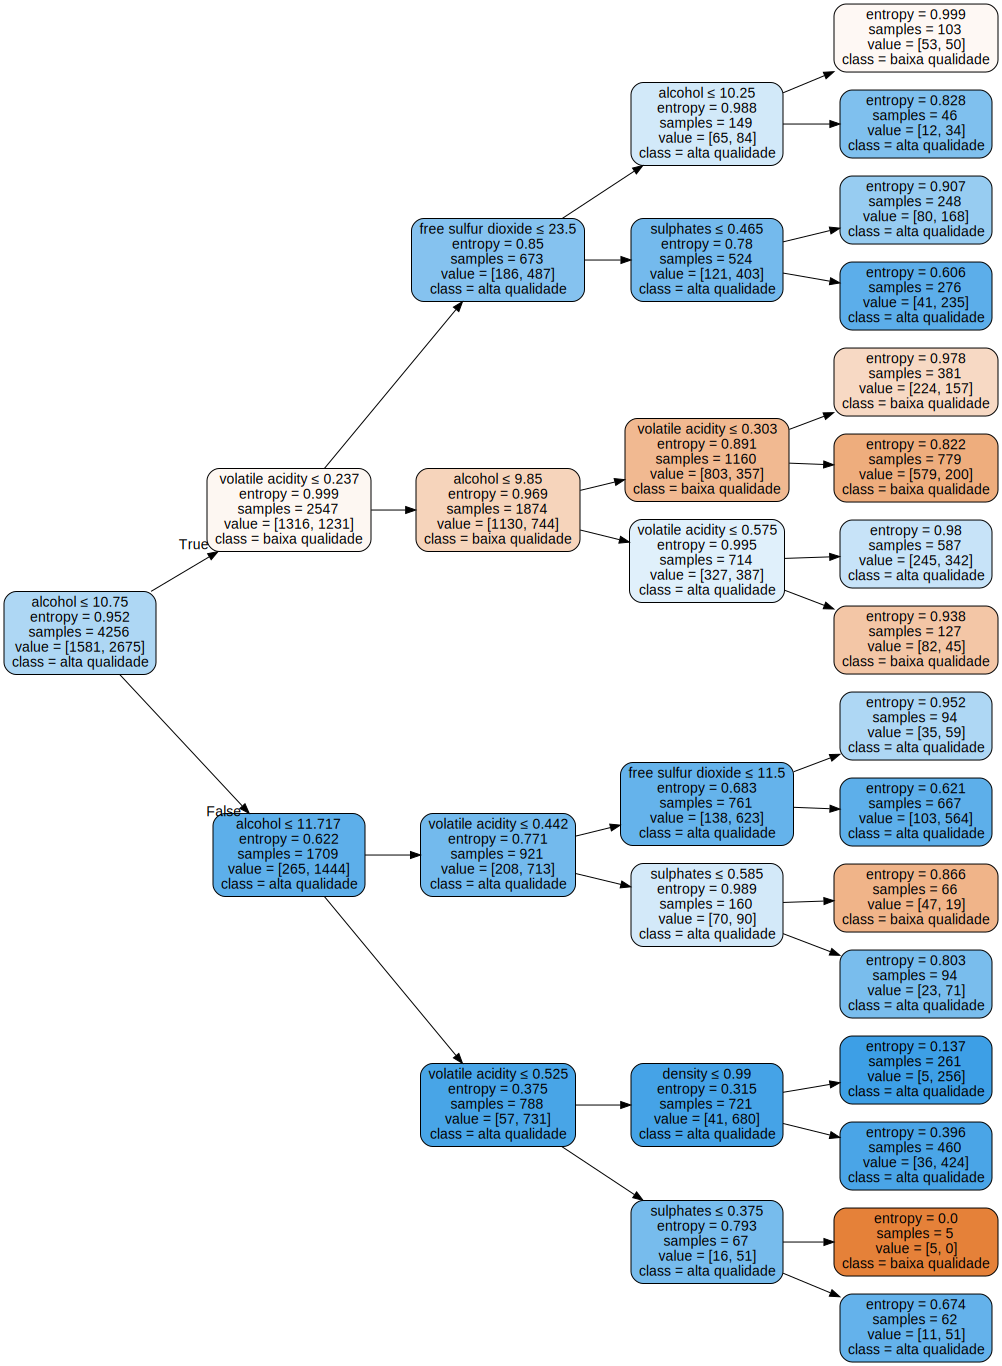

In [17]:
import graphviz
dot_data = tree.export_graphviz(model_wine, 
                  feature_names= wine_feature_names, 
                  leaves_parallel = True,
                  class_names=wine_label_map.target_label.values,  
                    filled=True, rounded=True,  
                  special_characters=True,
                                rotate=True,
                   out_file=None,
                           )
graph = graphviz.Source(dot_data)
# graph.format = "png"
# graph.render("./teste")
graph

### Distribuições 

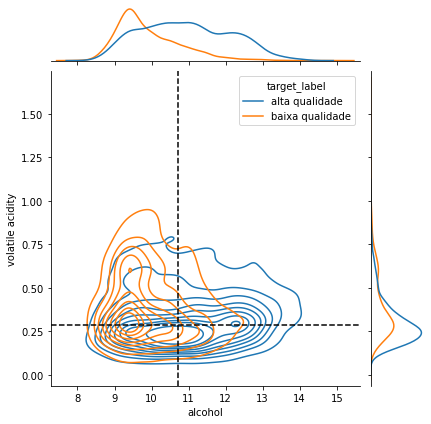

In [18]:
df = df_wine_tr.merge(wine_label_map, on='target')
ax = sns.jointplot(data=df, x='alcohol',y='volatile acidity',
              hue='target_label', kind='kde')

ax.ax_joint.axvline(x=10.725, linestyle='--', color='k')
ax.ax_joint.axhline(y=0.287, linestyle='--', color='k')


### Caminho da Árvore 

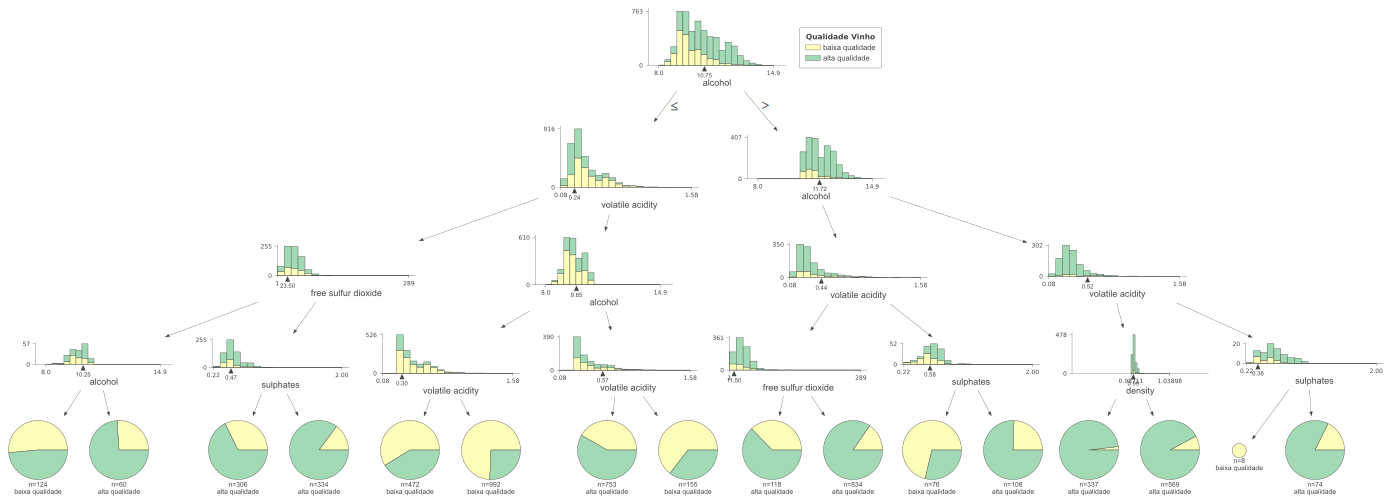

In [19]:
from dtreeviz.trees import dtreeviz # remember to load the package

viz = dtreeviz(model_wine, df_wine_tr[wine_feature_names],
               df_wine_tr[wine_target_col],
                target_name="Qualidade Vinho",
                feature_names=wine_feature_names,
                class_names=list(wine_label_map.target_label.values))

viz.save("./teste.svg")
viz

### Importância das Variáveis - Entropia

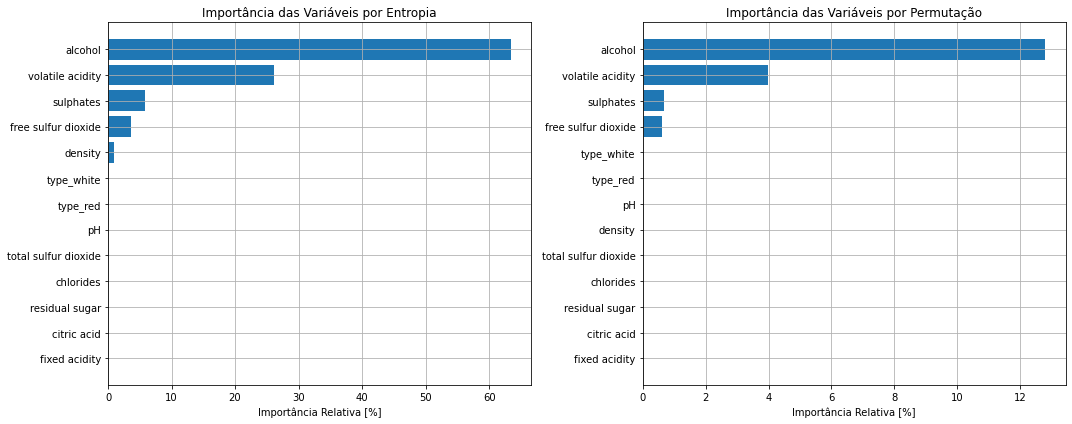

In [20]:
plt.figure(figsize=(15,6))


plt.subplot(1,2,1)
idx = np.argsort(model_wine.feature_importances_)

plt.barh(np.arange(idx.shape[0]), model_wine.feature_importances_[idx]*100)

plt.yticks(np.arange(idx.shape[0]), np.array(wine_feature_names)[idx])
plt.title('Importância das Variáveis por Entropia')
plt.grid()
plt.xlabel('Importância Relativa [%]')
plt.tight_layout()

plt.subplot(1,2,2)
r = permutation_importance(model_wine, xtest, ytest,
                           n_repeats=30,
                        random_state=0)
importance =  r.importances_mean
idx = np.argsort(importance)
plt.barh(np.arange(idx.shape[0]), importance[idx]*100)
plt.yticks(np.arange(idx.shape[0]), np.array(wine_feature_names)[idx])
plt.title('Importância das Variáveis por Permutação')
plt.grid()
plt.xlabel('Importância Relativa [%]')
plt.tight_layout()

In [21]:

Y = df_iris[iris_target_col]
X = df_iris.drop(iris_target_col, axis=1)
iris_feature_names = list(X.columns)

# train/test
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(X, Y, test_size=0.2)

df_train = xtrain.copy()
df_test = xtest.copy()
df_train['train_set'] = 1
df_test['train_set'] = 0
df_train[iris_target_col] = ytrain
df_test[iris_target_col] = ytest


model_iris = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 4)

model_iris.fit(xtrain, ytrain)      
df_train['decision_tr'] = model_iris.predict(xtrain)
df_test['decision_tr']  = model_iris.predict(xtest)
for icls in iris_label_map.target.unique():
    xclass = xtrain[ytrain==icls]
    idx = df_train[iris_target_col] == icls
    df_train.loc[idx,'probability_tr'] = model_iris.predict_proba(xclass)[:,icls]
    xclass = xtest[ytest==icls]
    idx = df_test[iris_target_col] == icls
    df_test.loc[idx,'probability_tr']  = model_iris.predict_proba(xclass)[:,icls]

df_iris_tr = pandas.concat((df_train, df_test), axis=0)

idx = df_iris_tr['train_set'] == 0

print('Decision Tree\t', metrics.accuracy_score(df_iris_tr[idx][iris_target_col],
                                                df_iris_tr[idx]['decision_tr']))

Decision Tree	 0.9


### Estrutura da Árvore 

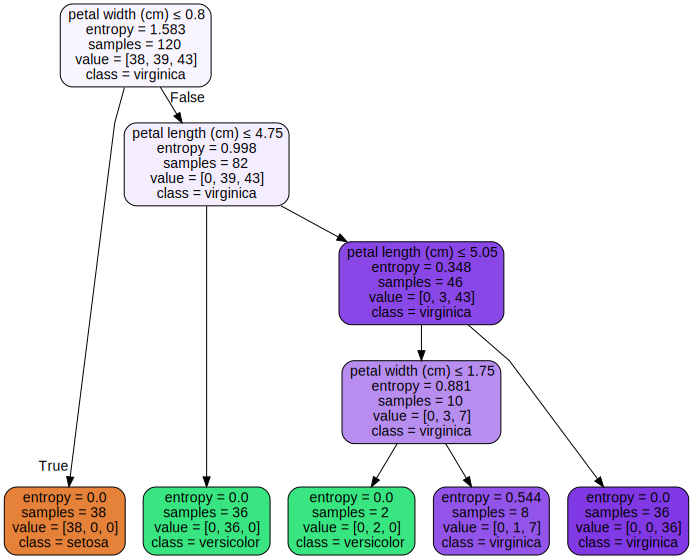

In [22]:
import graphviz
dot_data = tree.export_graphviz(model_iris, 
                  feature_names= iris_feature_names, 
                  leaves_parallel = True,
                  class_names=iris_label_map.target_label.values,  
                    filled=True, rounded=True,  
                  special_characters=True,
                                rotate=False,
                   out_file=None,
                           )
graph = graphviz.Source(dot_data)
graph.format = "png"
graph.render("./teste")
graph

### Caminho da Árvore 

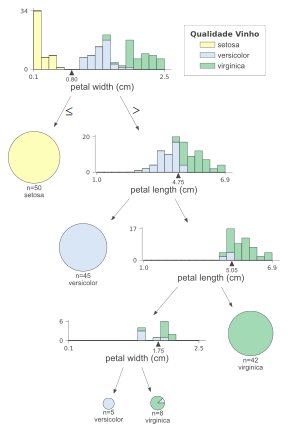

In [23]:
from dtreeviz.trees import dtreeviz # remember to load the package

viz = dtreeviz(model_iris, df_iris_tr[iris_feature_names],
               df_iris_tr[iris_target_col],
                target_name="Qualidade Vinho",
                feature_names=iris_feature_names,
                class_names=list(iris_label_map.target_label.values))

viz.save("./teste.svg")
viz

### Importância das Variáveis por Entropia 

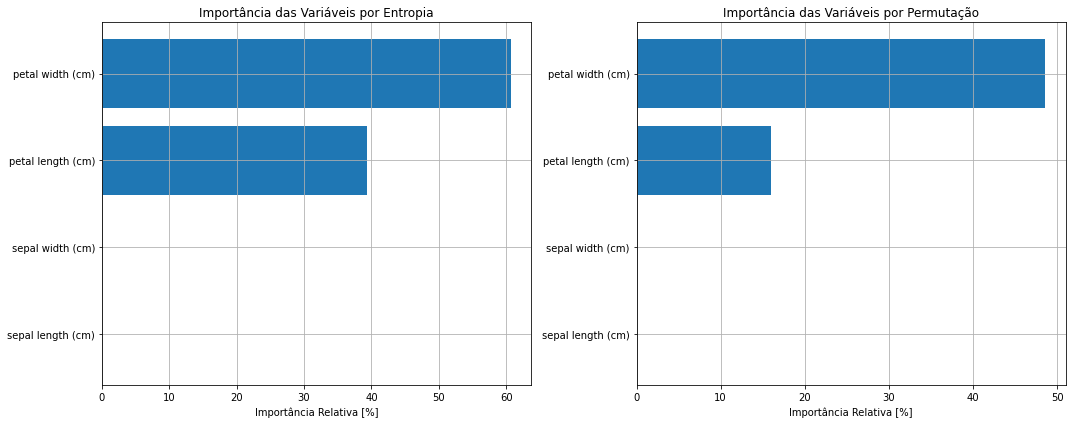

In [24]:
plt.figure(figsize=(15,6))


plt.subplot(1,2,1)
idx = np.argsort(model_iris.feature_importances_)

plt.barh(np.arange(idx.shape[0]), model_iris.feature_importances_[idx]*100)

plt.yticks(np.arange(idx.shape[0]), np.array(iris_feature_names)[idx])
plt.title('Importância das Variáveis por Entropia')
plt.grid()
plt.xlabel('Importância Relativa [%]')
plt.tight_layout()


plt.subplot(1,2,2)
r = permutation_importance(model_iris, xtest, ytest,
                           n_repeats=30,
                        random_state=0)
importance =  r.importances_mean
idx = np.argsort(importance)
plt.barh(np.arange(idx.shape[0]), importance[idx]*100)
plt.yticks(np.arange(idx.shape[0]), np.array(iris_feature_names)[idx])
plt.title('Importância das Variáveis por Permutação')
plt.grid()
plt.xlabel('Importância Relativa [%]')
plt.tight_layout()


# Regressao 

## Clima 

### Leitura dos dados 

In [25]:
df_weather = pandas.read_csv('../Data/dataset_clima.csv',sep=';')

drop_cols = ['Temperature (C)']
df_weather.drop(drop_cols, axis=1, inplace=True)

print(df_weather.shape)

weather_target_col = 'Apparent Temperature (C)'

df_weather.head()

(4019, 7)


,Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
0,-4.050,0.890,17.114,140.000,9.982,0.0,1016.660
1,-0.175,0.817,21.229,142.750,11.348,0.0,1011.985
2,1.809,0.847,17.825,164.583,8.492,0.0,1010.384
3,0.445,0.897,7.727,252.542,9.224,0.0,1021.171
4,-0.663,0.907,12.153,35.000,8.353,0.0,981.771


### Treinamento dos Modelos 

In [26]:

Y = df_weather[weather_target_col]
X = df_weather.drop(weather_target_col, axis=1)
weather_feature_names = list(X.columns)

# train/test
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(X, Y, test_size=0.2)


cvfold = model_selection.KFold(n_splits = 10, random_state = 0, shuffle=True)

### Regressão Linear 

#### Curva de Validação-Cruzada 

In [27]:
grid_search_el = {
    'alpha': [0.001, 0.01, 0.1, 1],
    'l1_ratio': np.linspace(0, 1, 5),
    'selection': ['cyclic', 'random'],
}

interact(plot_parameter_validation_curve,
         param_name = list(grid_search_el.keys()), 
         grid_search = fixed(grid_search_el),
         model = fixed(lm.ElasticNet()),
         model_name = fixed('ElasticNet'),
         scoring = regression_scores,
         logx = True
)

interactive(children=(Dropdown(description='param_name', options=('alpha', 'l1_ratio', 'selection'), value='al…

<function __main__.plot_parameter_validation_curve(param_name, grid_search, model, model_name, scoring, logx)>

#### Curva de Aprendizado 

In [28]:
train_sizes = np.linspace(.1, 1.0, 10)
    

interact(plot_learning_curve,
         model = fixed(lm.ElasticNet(alpha=1e-3)),
         model_name = fixed('ElasticNet'),
         scoring = regression_scores,
         train_sizes=fixed(train_sizes)
)


interactive(children=(Dropdown(description='scoring', options=('explained_variance', 'neg_mean_absolute_error'…

<function __main__.plot_learning_curve(model, model_name, scoring, train_sizes)>

### Árvore de Regressão 

#### Curva de Validação-Cruzada 

In [29]:
grid_search_dt = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 4, 6, 8],
    'max_features': ["auto", "sqrt", "log2"],
}

interact(plot_parameter_validation_curve,
         param_name = list(grid_search_dt.keys()), 
         grid_search = fixed(grid_search_dt),
         model = fixed(tree.DecisionTreeRegressor()),
         model_name = fixed('Árvore de Decisão'),
         scoring = regression_scores,
         logx = False
)

interactive(children=(Dropdown(description='param_name', options=('max_depth', 'criterion', 'min_samples_split…

<function __main__.plot_parameter_validation_curve(param_name, grid_search, model, model_name, scoring, logx)>

#### Curva de Aprendizado 

In [30]:
train_sizes = np.linspace(.1, 1.0, 10)
    

interact(plot_learning_curve,
         model = fixed(tree.DecisionTreeRegressor(max_depth=7)),
         model_name = fixed('Árvore de Decisão'),
         scoring = regression_scores,
         train_sizes=fixed(train_sizes)
)


interactive(children=(Dropdown(description='scoring', options=('explained_variance', 'neg_mean_absolute_error'…

<function __main__.plot_learning_curve(model, model_name, scoring, train_sizes)>

## Automóveis 

### Leitura dos Dados 

In [31]:
df_auto = pandas.read_csv('../Data/dataset_auto.csv',sep=';')
df_auto['model'] = df_auto['brand'].astype(str) + df_auto['model'].astype(str)

auto_target_col = 'price'

drop_cols = ['brand','tax']
df_auto.drop(drop_cols, axis=1, inplace=True)
print(df_auto.shape)
df_auto.head()

(15000, 8)


,model,year,price,transmission,mileage,fuelType,mpg,engineSize
0,audi A1,2020,20000,Manual,5000,Petrol,49.6,1.0
1,audi A5,2017,19995,Semi-Auto,54000,Diesel,67.3,2.0
2,audi A3,2017,11895,Manual,28334,Petrol,62.8,1.0
3,audi Q7,2018,56900,Semi-Auto,5330,Diesel,39.2,4.0
4,audi A4,2019,27160,Semi-Auto,17790,Diesel,47.9,2.0


### Variáveis Categóricas 

In [32]:
categorical_cols = ['transmission', 'fuelType', 'model']
encoder_map = {}

for cname in categorical_cols:
    encoder = preprocessing.OneHotEncoder(sparse=False)
    transformed = encoder.fit_transform(df_auto[[cname]])
    ohe_df = pandas.DataFrame(transformed, columns=[cname+'_'+cat for cat in encoder.categories_[0]])
    encoder_map[cname] = encoder
    
    df_auto = pandas.concat([df_auto, ohe_df], axis=1).drop(cname, axis=1)
df_auto.head()

,year,price,mileage,mpg,engineSize,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Electric,...,model_ford Ka+,model_ford Kuga,model_ford Mondeo,model_ford Mustang,model_ford Puma,model_ford S-MAX,model_ford Streetka,model_ford Tourneo Connect,model_ford Tourneo Custom,model_ford Transit Tourneo
0,2020,20000,5000,49.6,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017,19995,54000,67.3,2.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017,11895,28334,62.8,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018,56900,5330,39.2,4.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019,27160,17790,47.9,2.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Treinamento dos Modelos 

In [35]:

Y = df_auto[auto_target_col]
X = df_auto.drop(auto_target_col, axis=1)
auto_feature_names = list(X.columns)

# train/test
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(X, Y, test_size=0.2)

cvfold = model_selection.KFold(n_splits = 10, random_state = 0, shuffle=True)


In [36]:
import graphviz
dot_data = tree.export_graphviz(model_auto, 
                  feature_names= auto_feature_names, 
                  leaves_parallel = True, 
                    filled=True, rounded=True,  
                  special_characters=True,
                                rotate=False,
                   out_file=None,
                    max_depth=3
                           )
graph = graphviz.Source(dot_data)
graph.format = "png"
graph.render("./teste")
graph

NameError: name 'model_auto' is not defined

### Regressão Linear 

#### Curva de Validação 

In [37]:
grid_search_el = {
    'alpha': [0.001, 0.01, 0.1, 1],
    'l1_ratio': np.linspace(0, 1, 5),
    'selection': ['cyclic', 'random'],
}

interact(plot_parameter_validation_curve,
         param_name = list(grid_search_el.keys()), 
         grid_search = fixed(grid_search_el),
         model = fixed(lm.ElasticNet()),
         model_name = fixed('ElasticNet'),
         scoring = regression_scores,
         logx = True
)

interactive(children=(Dropdown(description='param_name', options=('alpha', 'l1_ratio', 'selection'), value='al…

<function __main__.plot_parameter_validation_curve(param_name, grid_search, model, model_name, scoring, logx)>

#### Curva de Aprendizado 

In [38]:
train_sizes = np.linspace(.1, 1.0, 10)
    

interact(plot_learning_curve,
         model = fixed(lm.ElasticNet(alpha=1e-3)),
         model_name = fixed('ElasticNet'),
         scoring = regression_scores,
         train_sizes=fixed(train_sizes)
)


interactive(children=(Dropdown(description='scoring', options=('explained_variance', 'neg_mean_absolute_error'…

<function __main__.plot_learning_curve(model, model_name, scoring, train_sizes)>

### Árvore de Regressão 

#### Curva de Validação-Cruzada 

In [39]:
grid_search_dt = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 4, 6, 8],
    'max_features': ["auto", "sqrt", "log2"],
}

interact(plot_parameter_validation_curve,
         param_name = list(grid_search_dt.keys()), 
         grid_search = fixed(grid_search_dt),
         model = fixed(tree.DecisionTreeRegressor()),
         model_name = fixed('Árvore de Decisão'),
         scoring = regression_scores,
         logx = False
)

interactive(children=(Dropdown(description='param_name', options=('max_depth', 'criterion', 'min_samples_split…

<function __main__.plot_parameter_validation_curve(param_name, grid_search, model, model_name, scoring, logx)>

#### Curva de Aprendizado 

In [40]:
train_sizes = np.linspace(.1, 1.0, 10)
    

interact(plot_learning_curve,
         model = fixed(lm.ElasticNet(alpha=1e-3)),
         model_name = fixed('ElasticNet'),
         scoring = regression_scores,
         train_sizes=fixed(train_sizes)
)


interactive(children=(Dropdown(description='scoring', options=('explained_variance', 'neg_mean_absolute_error'…

<function __main__.plot_learning_curve(model, model_name, scoring, train_sizes)>